# Capstone: Airbnb Price Listing Prediction
##### Part 2 - Full EDA and Time Series Analysis

_Authors: Evonne Tham_

<div class="alert alert-block alert-warning">


<b>Checkin 3</b>

The actual deliverable for this section is fairly small. You are expected to submit, via this Google form, a progress report detailing where you are with your Capstone. The format and content is up to you but, at a minimum, we expect the following:


- ~~Do you have data fully in hand and if not, what blockers are you facing?~~
- Have you done a full EDA on all of your data?
- Have you begun the modeling process? How accurate are your predictions so far?
- What blockers are you facing, including processing power, data acquisition, modeling difficulties, data cleaning, etc.? How can we help you overcome those challenges?
- ~~Have you changed topics since your lightning talk? Since you submitted your Problem Statement and EDA? If so, do you have the necessary data in hand (and the requisite EDA completed) to continue moving forward?~~
- ~~What is your timeline for the next week and a half? What do you have to get done versus what would you like to get done?~~
- ~~What topics do you want to discuss during your 1:1?~~
- ~~We will use your progress report as a leaping off point for a deep 1:1 with a member of the instructional staff. The best use of your time is to really flesh out this document so that your remaining time here can be most productive.~~

- Examine the distributions of your data, numerically and/or visually.
- Identify outliers.

</div>

Color Codes 
- RdYlGn
- colors = ['#FF5A5F', '#00A699', '#FC642D']

##  1. Import Necessary Libraries & Load Data 

In [1]:
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt
import seaborn as sns   
%matplotlib inline

# Geographical Analysis
import geopandas as gpd

#Hide warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load in Data 
final = pd.read_csv('../datasets/final.csv')
print(f"Total Number of Listing: {final.shape[0]} | Total Number of Features: {final.shape[1]}")
final.head().T

Total Number of Listing: 12345 | Total Number of Features: 46


,0,1,2,3,4
id,35303,197677,289597,370759,700253
host_id,151977,964081,341577,1573631,341577
host_since,2010-06-25,2011-08-13,2011-01-10,2012-01-06,2011-01-10
host_response_time,unknown,within a few hours,within a few hours,within a day,within a few hours
host_response_rate,unknown,100%,100%,100%,100%
host_acceptance_rate,unknown,50-89%,50-89%,90-99%,50-89%
host_is_superhost,0,1,0,1,0
host_listings_count,3,1,2,3,2
host_identity_verified,1,1,1,1,1
neighbourhood,Shibuya Ku,Sumida Ku,Nerima Ku,Setagaya Ku,Nerima Ku


##  2. Full Exploratory Analysis

##### Price (Target Variable)

In [3]:
print(f"Nightly advertised prices range from {min(final.price)}¥ to {max(final.price)}¥.")

Nightly advertised prices range from 1075¥ to 1000040¥.


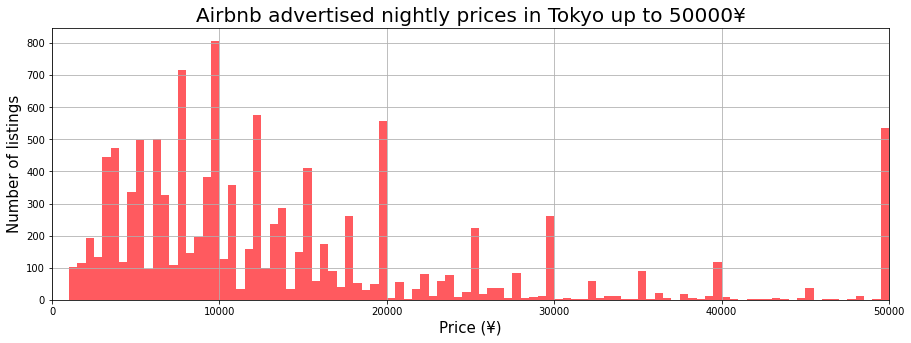

In [4]:
# Distribution of prices up to 50_000 yen 
plt.figure(figsize=(15,5))

final.price.hist(bins=100, 
                 range=(0, 50_000),
                 color ='#FF5A5F')

plt.margins(x=0)
plt.title("Airbnb advertised nightly prices in Tokyo up to 50000¥", fontsize=20)
plt.xlabel("Price (¥)", fontsize=15)
plt.ylabel("Number of listings", fontsize=15);

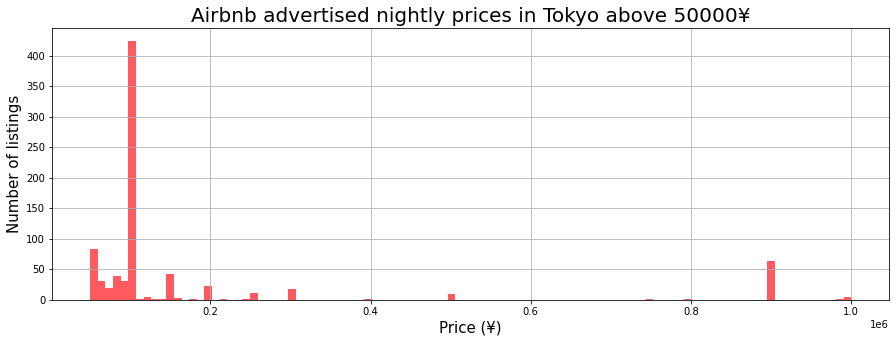

In [5]:
# Distribution of prices up to 50_000 yen 
plt.figure(figsize=(15,5))

final.price.hist(bins=100, 
                 range=(50_000, max(final.price)),
                 color ='#FF5A5F')

plt.title("Airbnb advertised nightly prices in Tokyo above 50000¥", fontsize=20)
plt.xlabel("Price (¥)", fontsize=15)
plt.ylabel("Number of listings", fontsize=15);

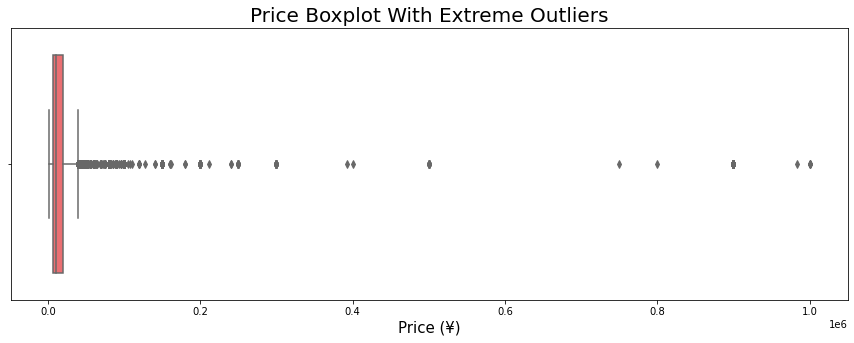

In [6]:
plt.figure(figsize =(15,5))

sns.boxplot(final.price, color = '#FF5A5F')
plt.title('Price Boxplot With Extreme Outliers', fontsize=20)
plt.xlabel('Price (¥)', fontsize = 15);

_There are quite a number of listing that are price above 100000 yen. Hence I will be leaving those untouch and drop those that are priced above that and are of lesser frequency._


<img src="../image/listing_over_100000.png"
	title="Listing over 100000¥" width="1050" height="1000" />

In [7]:
# Drop rows that are listed above 100000 Yen
final.drop(final[final['price'] > 100_000].index, inplace=True)

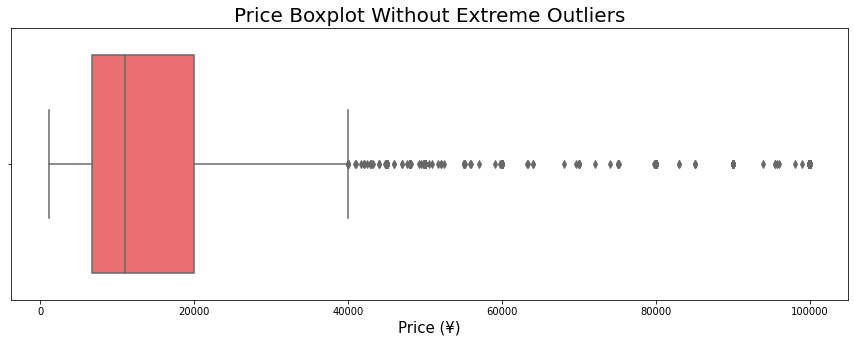

In [8]:
plt.figure(figsize =(15,5))

sns.boxplot(final.price, color = '#FF5A5F')
plt.title('Price Boxplot Without Extreme Outliers', fontsize=20)
plt.xlabel('Price (¥)', fontsize = 15);

<div class="alert alert-block alert-success">

<b>Observation:</b>

Listing prices have a right skewed distribution
</div>

##### Host

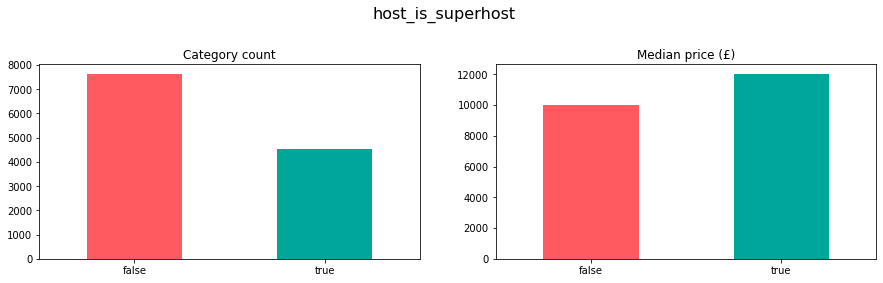

0    0.628785
1    0.371215
Name: host_is_superhost, dtype: float64


In [9]:
def binary_count_and_price_plot(col, figsize=(15,4)):
    """
    Plots a simple bar chart of the counts of true and false categories in the column specified,
    next to a bar chart of the median price for each category.
    A figure size can optionally be specified.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(col, fontsize=16, y=1)
    plt.subplots_adjust(top=0.80) # So that the suptitle does not overlap with the ax plot titles
    
    final.groupby(col).size().plot(kind='bar', ax=ax1, color=['#FF5A5F', '#00A699'])
    ax1.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax1.set_title('Category count')
    ax1.set_xlabel('')
    
    final.groupby(col).price.median().plot(kind='bar', ax=ax2, color=['#FF5A5F', '#00A699'])
    ax2.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax2.set_title('Median price (£)')
    ax2.set_xlabel('')
    
    plt.show()

binary_count_and_price_plot('host_is_superhost')
print(final.host_is_superhost.value_counts(normalize=True));

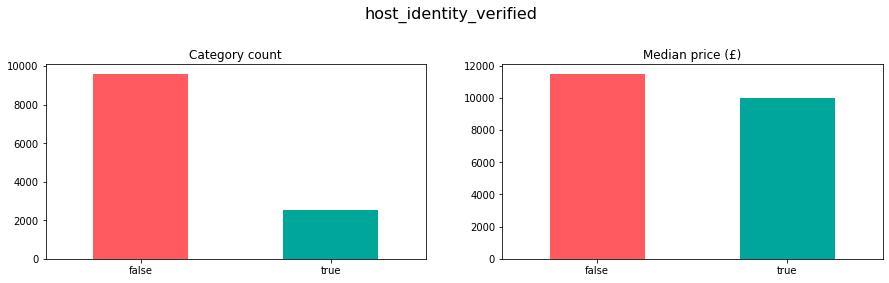

0    0.790487
1    0.209513
Name: host_identity_verified, dtype: float64


In [10]:
binary_count_and_price_plot('host_identity_verified')
print(final.host_identity_verified.value_counts(normalize=True));

<div class="alert alert-block alert-success">

<b>Observation:</b>

About 37% of hosts are superhosts and about 20% of hosts are verified. However, it does not seem to improve the median price per night of their Airbnb listings.
</div>

##### Host Listing Count

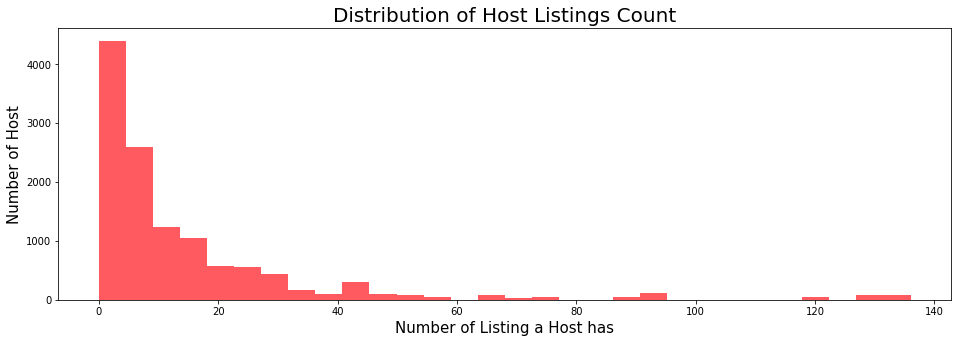

In [11]:
plt.figure(figsize=(16,5))
plt.hist(final['host_listings_count'], bins=30, color ='#FF5A5F')
plt.title('Distribution of Host Listings Count', fontsize=20)
plt.xlabel('Number of Listing a Host has', fontsize=15)
plt.ylabel('Number of Host', fontsize=15);

In [12]:
final[final['host_listings_count']==0]

,id,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,time_since_first_review
18,1394409,7537357,2013-07-17,within a few hours,100%,0-49%,0,0,0,Toshima Ku,...,90-99%,10,9,10,10,10,10,0,moderate,2272 days 00:00:00.000000000
19,1394737,7537357,2013-07-17,within a few hours,100%,0-49%,0,0,0,Toshima Ku,...,90-99%,10,10,10,10,10,10,0,moderate,2334 days 00:00:00.000000000
50,2839061,4839990,2013-01-25,unknown,unknown,50-89%,1,0,0,Bunkyo Ku,...,90-99%,10,10,10,10,10,10,0,strict,1720 days 00:00:00.000000000
151,5198467,25911199,2015-01-10,within a few hours,100%,50-89%,0,0,1,Bunkyo Ku,...,90-99%,10,10,10,10,9,10,0,strict,1857 days 00:00:00.000000000
527,10110295,46443714,2015-10-13,within a day,100%,50-89%,0,0,1,Shibuya Ku,...,90-99%,9,9,9,10,10,9,0,moderate,1516 days 00:00:00.000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12320,43198704,255274063,2019-04-11,within an hour,100%,100%,0,0,0,Taito Ku,...,100%,10,10,8,10,10,10,1,strict,0 days 00:00:00.000000000
12321,43230220,343773365,2020-04-13,within an hour,100%,100%,0,0,1,Sumida Ku,...,100%,10,10,10,10,10,10,1,strict,7 days 00:00:00.000000000
12323,43249399,159202994,2017-11-18,within an hour,100%,100%,0,0,0,Ota Ku,...,90-99%,10,10,10,10,9,10,1,flexible,20 days 00:00:00.000000000
12340,43351388,341058704,2020-03-10,within an hour,100%,100%,0,0,0,Edogawa Ku,...,100%,10,10,10,10,10,10,1,strict,0 days 00:00:00.000000000


In [13]:
final.drop(final[final['host_listings_count']==0].index, inplace=True)
final.shape

(11456, 46)

In [14]:
print("Median number of listings per host:", int(final.host_listings_count.median()))
print("Mean number of listings per host:", int(round(final.host_listings_count.mean())))
print(f"{int(round(100*len(final[final.host_listings_count == 1])/len(final)))}% of listings are from hosts with one listing.")

Median number of listings per host: 8
Mean number of listings per host: 16
10% of listings are from hosts with one listing.


<div class="alert alert-block alert-success">

<b>Assumption:</b>

Listing which leaves host with zero listing counts are dropped. Assumption being these users signed up as host but have yet to list any property. Hence, it will not affect the prediction. 

<b>Observation:</b>

According to the numbers above, it seems like hosts in Tokyo manages quite a number of properties. 

</div>

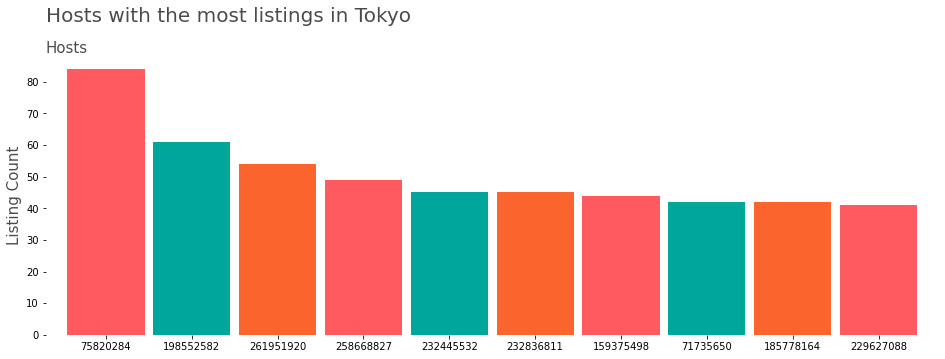

In [15]:
top_host=final.host_id.value_counts().head(10)

fig = plt.figure(1, figsize=(16,5))
ax = fig.add_subplot(111)

title = 'Hosts with the most listings in Tokyo'

transparency = 0.7
color = ['#FF5A5F', '#00A699', '#FC642D']

top_host.plot(kind = 'bar', 
              color = color, 
              width = 0.9,
              title = title)

ax.grid(False)
ax.set_frame_on(False)

ax.set_title(ax.get_title(), fontsize=20, alpha=transparency, ha='left')
plt.subplots_adjust(top=0.9)
ax.title.set_position((0,1.1))

ax.xaxis.set_label_position('top')
xlab = 'Hosts'
ax.set_xlabel(xlab, fontsize=15, alpha=transparency, ha='left')
ax.xaxis.set_label_coords(0, 1.01)
plt.xticks(rotation=0)

ylab = 'Listing Count'
ax.set_ylabel(ylab, fontsize=15, alpha=transparency);

<div class="alert alert-block alert-success">

<b>Observation:</b>

These are the host with most number of listing in Tokyo. Host 75820284 has over 80 listings. 


</div>

##### Neighbourhod

In [16]:
# Create new dataframe for neighbourhood count
neighbourhood_count = pd.DataFrame()
neighbourhood_count['total_hosts'] = final['neighbourhood'].value_counts()

# Filter out neighbourhood with less than 20 listings
neighbourhood_count = neighbourhood_count[neighbourhood_count['total_hosts'] > 20]
neighbourhood_count.sort_index(ascending=True, inplace=True)

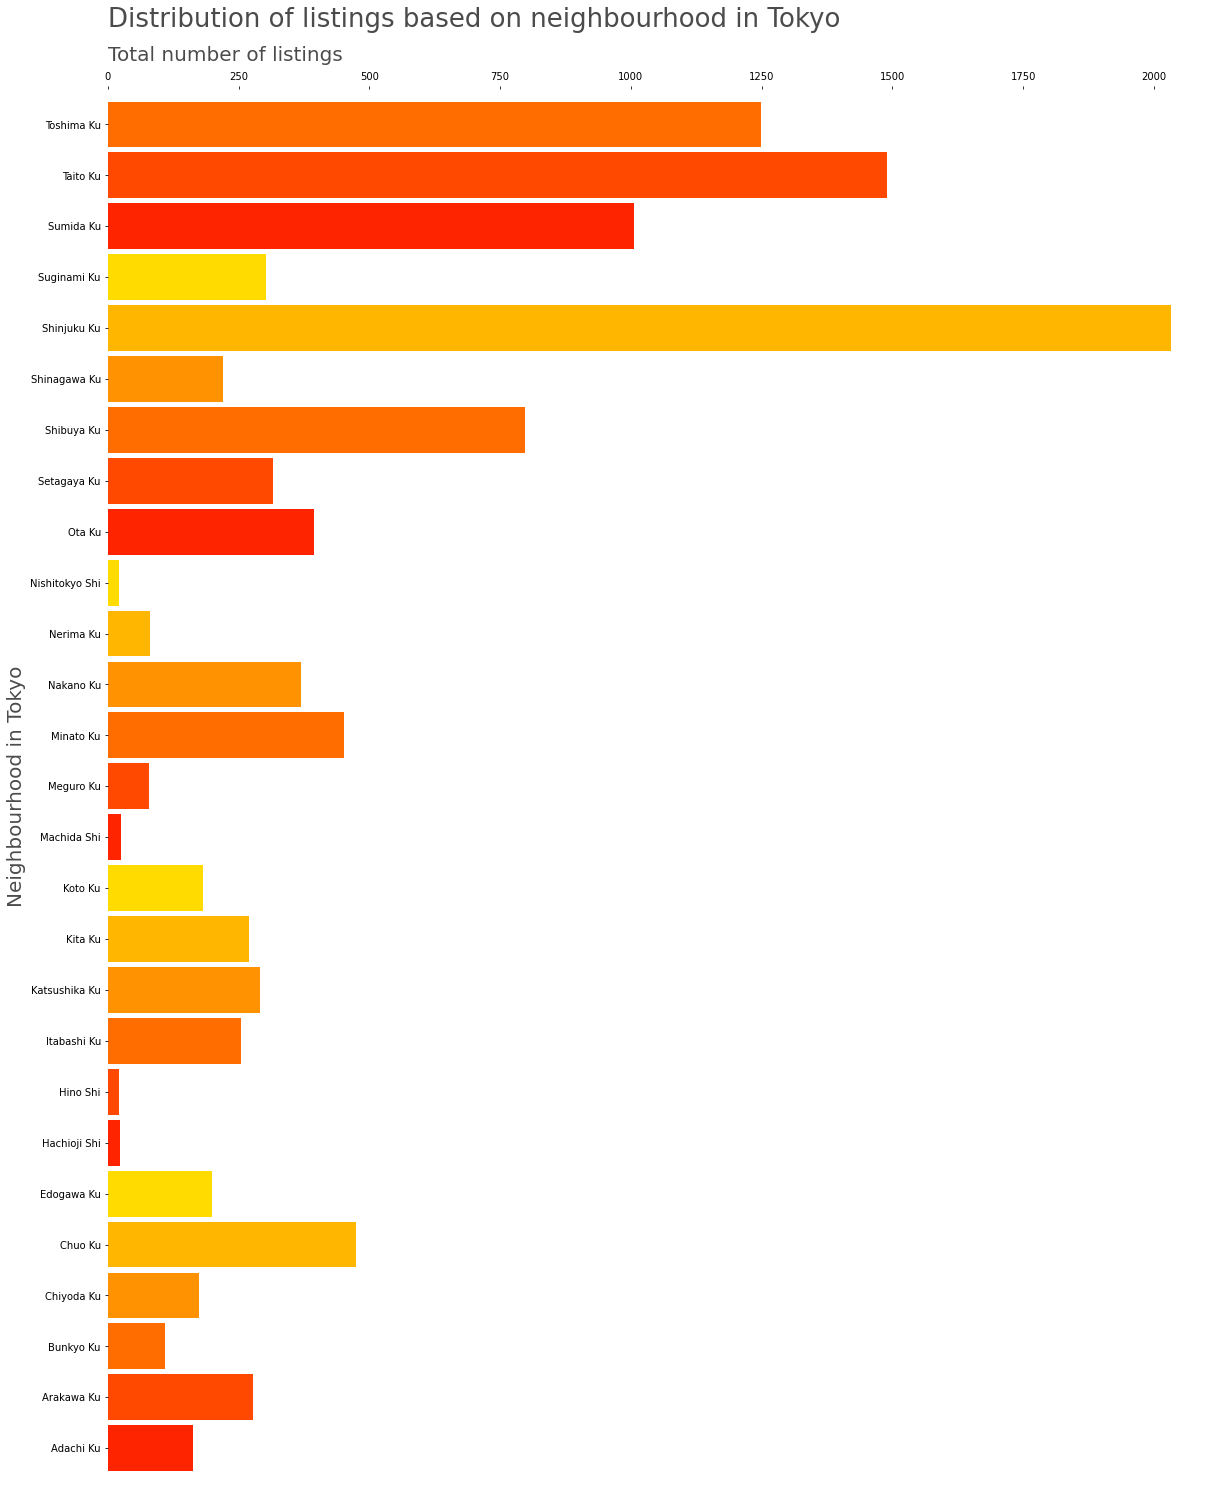

In [17]:
fig = plt.figure(1, figsize=(20,25))
ax = fig.add_subplot(111)

title="Distribution of listings based on neighbourhood in Tokyo"

transparency = 0.7
cmap = sns.color_palette("autumn")

neighbourhood_count['total_hosts'].plot(kind = 'barh',
                                        ax = ax,
                                        color = cmap,
                                        title = title, 
                                        width = 0.9)

ax.grid(False)
ax.set_frame_on(False)

ax.set_title(ax.get_title(), fontsize=26, alpha=transparency, ha='left')
plt.subplots_adjust(top=0.9)
ax.title.set_position((0,1.04))

ax.xaxis.set_label_position('top')
xlab = 'Total number of listings'
ax.set_xlabel(xlab, fontsize=20, alpha=transparency, ha='left')
ax.xaxis.set_label_coords(0, 1.02)
ax.xaxis.tick_top()

ylab = 'Neighbourhood in Tokyo'
ax.set_ylabel(ylab, fontsize=20, alpha=transparency);

<div class="alert alert-block alert-success">

<b>Observation:</b>

In the chart above, Shinjuku Ku, Taito Ku, Toshima Ku, Sumida Ku, and Shibuya Ku are listed to have the highest number of listing. With about 2000 listings in Shinjuku Ku alone. This is not surprising as Shinjuku Ku is only of the most popular spots to visit as a tourist.


</div>

In [18]:
# top_neighbourhood = 

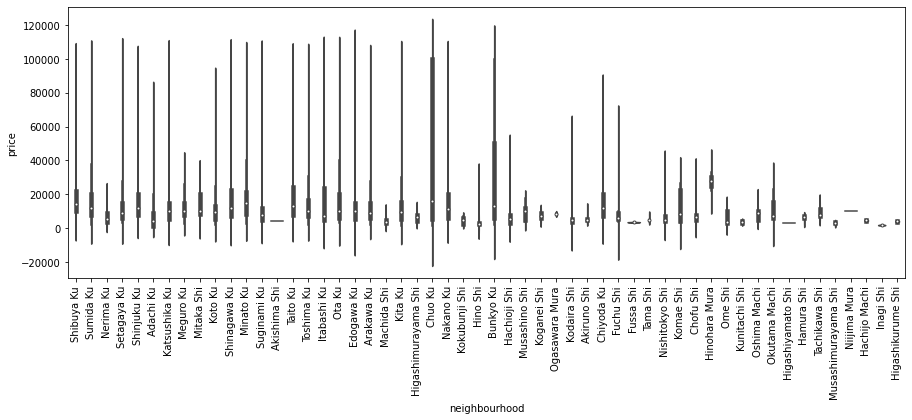

In [19]:
plt.figure(1, figsize=(15,5))
sns.violinplot('neighbourhood', 'price', data=final)
plt.xticks(rotation=90);

##### Property Type

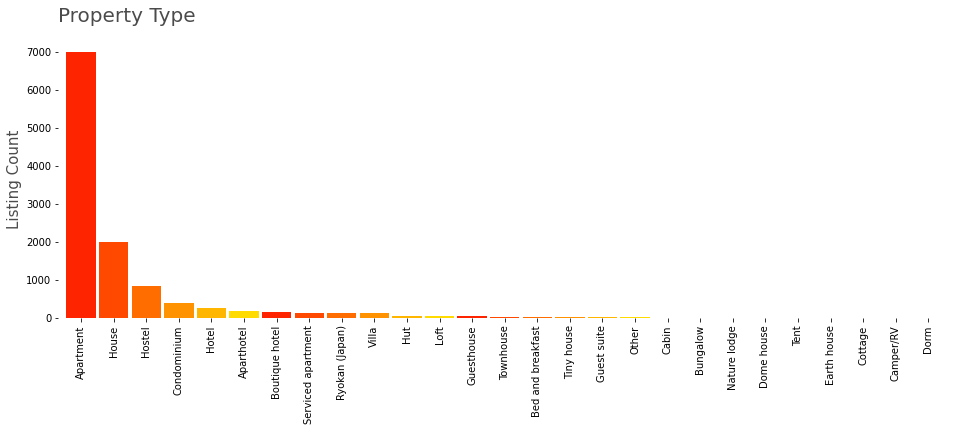

In [20]:
fig = plt.figure(1, figsize=(16,5))
ax = fig.add_subplot(111)

title = 'Property Type'

transparency = 0.7
color = sns.color_palette("autumn")

final['property_type'].value_counts().plot(kind='bar', 
                                           color = color, 
                                           width = 0.9,
                                           title = title)

ax.grid(False)
ax.set_frame_on(False)

ax.set_title(ax.get_title(), fontsize=20, alpha=transparency, ha='left')
plt.subplots_adjust(top=0.9)
ax.title.set_position((0,1.04))

ylab = 'Listing Count'
ax.set_ylabel(ylab, fontsize=15, alpha=transparency);

In [21]:
print(final.property_type.value_counts(normalize=True))

Apartment             0.610073
House                 0.173446
Hostel                0.073760
Condominium           0.033956
Hotel                 0.022608
Aparthotel            0.016672
Boutique hotel        0.013181
Serviced apartment    0.011522
Ryokan (Japan)        0.011348
Villa                 0.010737
Hut                   0.003841
Loft                  0.003492
Guesthouse            0.003317
Townhouse             0.002881
Bed and breakfast     0.002095
Tiny house            0.001659
Guest suite           0.001659
Other                 0.001222
Cabin                 0.000786
Bungalow              0.000436
Nature lodge          0.000349
Dome house            0.000349
Tent                  0.000262
Earth house           0.000087
Cottage               0.000087
Camper/RV             0.000087
Dorm                  0.000087
Name: property_type, dtype: float64


<div class="alert alert-block alert-success">

<b>Observation:</b>

Most common listings property type: Apartment (More than 61%)


</div>

##### Room Type

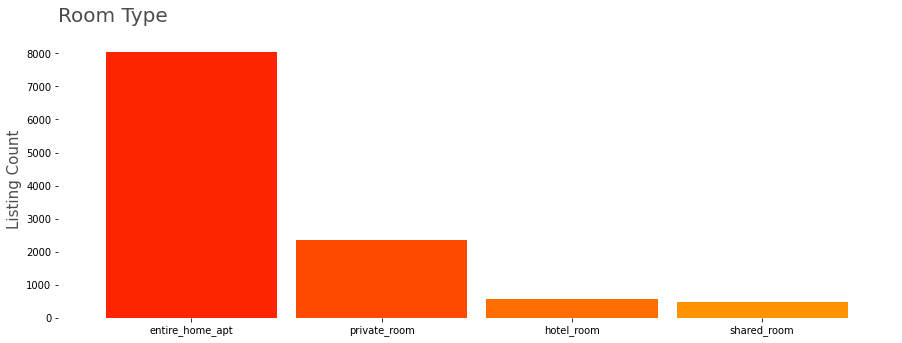

In [22]:
fig = plt.figure(1, figsize=(15,5))
ax = fig.add_subplot(111)

title = 'Room Type'

transparency = 0.7
color = sns.color_palette("autumn")

final['room_type'].value_counts().plot(kind='bar',
                                       color = color,
                                       width = 0.9, 
                                       title = title)

ax.grid(False)
ax.set_frame_on(False)

ax.set_title(ax.get_title(), fontsize=20, alpha=transparency, ha='left')
plt.subplots_adjust(top=0.9)
ax.title.set_position((0,1.04))
plt.xticks(rotation=0)

ylab = 'Listing Count'
ax.set_ylabel(ylab, fontsize=15, alpha=transparency);
print()

In [23]:
print(final.room_type.value_counts(normalize=True))

entire_home_apt    0.701379
private_room       0.206442
hotel_room         0.050279
shared_room        0.041899
Name: room_type, dtype: float64


<div class="alert alert-block alert-success">

<b>Observation:</b>

With more than 11000 listing, about 8000 of them are entire_home_apt and only 20% are private room. 

</div>

##### Property Vs Room Type

In [24]:
# Create a dataframe with property_type and room_type
property_room = final.groupby(['property_type','room_type']).room_type.count().unstack()

# Sum up the total number of room types in a property type
property_room['total'] = property_room.iloc[:,0:4].sum(axis = 1)
property_room.sort_values(by='total', inplace=True)

# Filter out properties that are less than 100
property_room = property_room[property_room['total']>=100]
property_room = property_room.drop(['total'], axis=1)

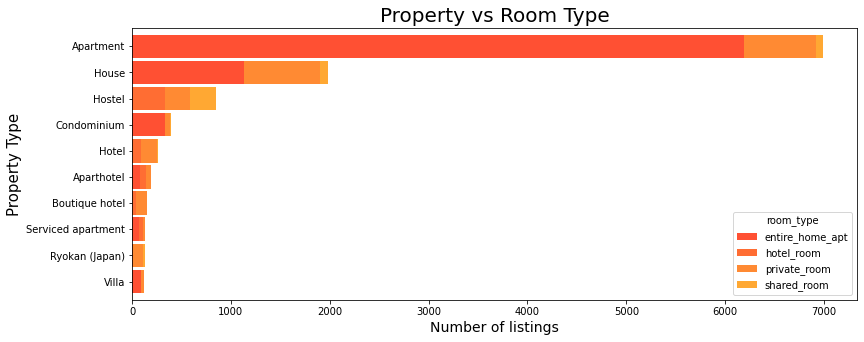

In [25]:
color = sns.color_palette("autumn")

property_room.plot(kind='barh',
                   stacked=True, 
                   color = color,
                   width=0.9,
                   figsize=(13,5), 
                   alpha = 0.8)

plt.title('Property vs Room Type', fontsize=20)
plt.xlabel('Number of listings', fontsize=14)
plt.ylabel("Property Type", fontsize=15);

<div class="alert alert-block alert-success">

<b>Observation:</b>

As shown in the figure above, most listings are categorised as apartments which comes in 3 top room types which are entire home, hotel room, and private room


</div>

##### Accomodates

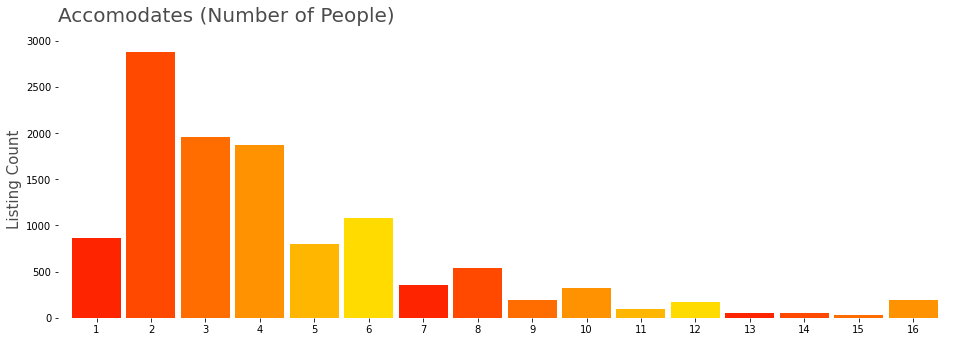

In [26]:
fig = plt.figure(1, figsize=(16,5))
ax = fig.add_subplot(111)

title = 'Accomodates (Number of People)'

transparency = 0.7
color = sns.color_palette("autumn")

final['accommodates'].value_counts().sort_index().plot(kind='bar', 
                                             color = color, 
                                             width = 0.9, 
                                             title = title)

ax.grid(False)
ax.set_frame_on(False)

ax.set_title(ax.get_title(), fontsize=20, alpha=transparency, ha='left')
plt.subplots_adjust(top=0.9)
ax.title.set_position((0,1.04))
plt.xticks(rotation=0)

ylab = 'Listing Count'
ax.set_ylabel(ylab, fontsize=15, alpha=transparency);

<div class="alert alert-block alert-success">

<b>Observation:</b>

Most listings in Tokyo are for 2-4 people

</div>

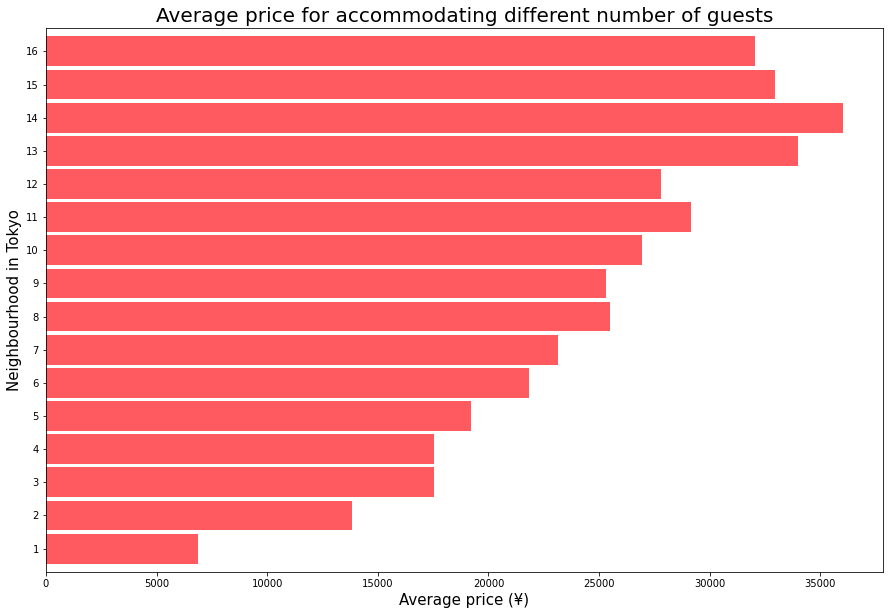

In [27]:
plt.figure(figsize=(15, 10))

color = '#FF5A5F'

final.groupby('accommodates').price.mean().plot.barh(color = color, 
                                                     width=0.9)

plt.title("Average price for accommodating different number of guests", fontsize=20)
plt.xlabel('Average price (¥)', fontsize=15)
plt.ylabel('Neighbourhood in Tokyo', fontsize=15);

<div class="alert alert-block alert-success">

<b>Observation:</b>


</div>

##### Rooms

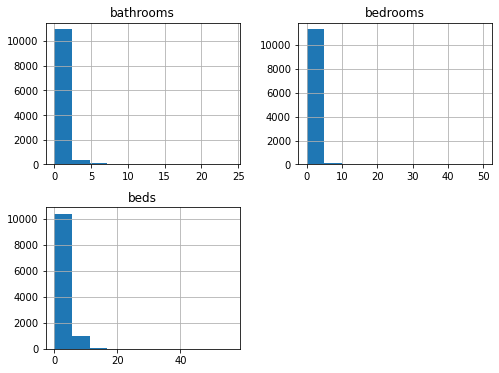

In [28]:
final[['bathrooms', 'bedrooms', 'beds']].hist(figsize=(8,6));

##### Review_Scores

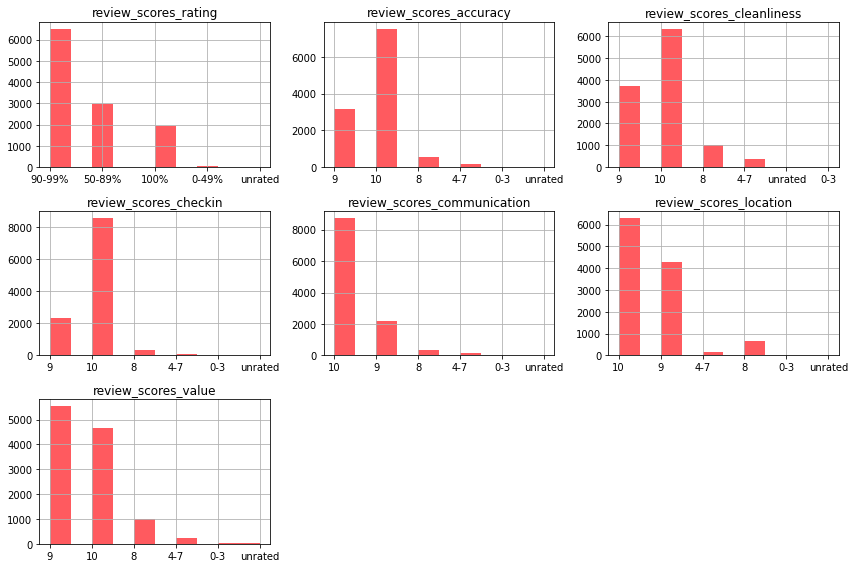

In [29]:
review_col = list(final.columns[final.columns.str.startswith("review_scores") == True])

fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(review_col):
    ax = fig.add_subplot(3,3,i+1)
    final[var_name].hist(bins=10, ax=ax, color = '#FF5A5F')
    ax.set_title(var_name)
    
fig.tight_layout()

In [30]:
review_group = pd.DataFrame(final.groupby('number_of_reviews').sum()['host_id'])
most_reviewed = (review_group.sort_values('number_of_reviews', ascending=False)).head(10)
most_reviewed['total_reviews'] = most_reviewed.index
most_reviewed.reset_index(drop=True, inplace=True)
most_reviewed

,host_id,total_reviews
0,209813314,529
1,206086589,526
2,150672186,488
3,21004633,475
4,194869594,407
5,219387975,347
6,6606987,339
7,205162345,330
8,6606987,319
9,85418859,317


##### Geographical Analysis

In [31]:
tokyo_map = gpd.read_file('../datasets/japan/neighbourhoods.geojson')
tokyo_map.head()

,neighbourhood,neighbourhood_group,geometry
0,Edogawa Ku,None,"MULTIPOLYGON (((139.85780 35.63580, 139.85530 ..."
1,Mizuho Machi,None,"MULTIPOLYGON (((139.32091 35.77720, 139.32359 ..."
2,Katsushika Ku,None,"MULTIPOLYGON (((139.84680 35.79653, 139.85640 ..."
3,Shinagawa Ku,None,"MULTIPOLYGON (((139.77280 35.59560, 139.76680 ..."
4,Koto Ku,None,"MULTIPOLYGON (((139.82120 35.63413, 139.82040 ..."


In [32]:
# Drop neighhourhood_group (None)
tokyo_map.drop('neighbourhood_group', axis=1, inplace=True)

# Create a dataframe for geographical analysis
neighbourhood_df = pd.DataFrame(final.groupby('neighbourhood').size())
neighbourhood_df.rename(columns={0: 'total_listings'}, inplace=True)
neighbourhood_df['median_price'] = final.groupby('neighbourhood').price.median().values
tokyo_map = tokyo_map.set_index('neighbourhood').join(neighbourhood_df)
tokyo_map.head()

,geometry,total_listings,median_price
neighbourhood,,,
Edogawa Ku,"MULTIPOLYGON (((139.85780 35.63580, 139.85530 ...",200.0,9850.5
Mizuho Machi,"MULTIPOLYGON (((139.32091 35.77720, 139.32359 ...",NaN,NaN
Katsushika Ku,"MULTIPOLYGON (((139.84680 35.79653, 139.85640 ...",290.0,9782.0
Shinagawa Ku,"MULTIPOLYGON (((139.77280 35.59560, 139.76680 ...",221.0,11968.0
Koto Ku,"MULTIPOLYGON (((139.82120 35.63413, 139.82040 ...",182.0,9352.0


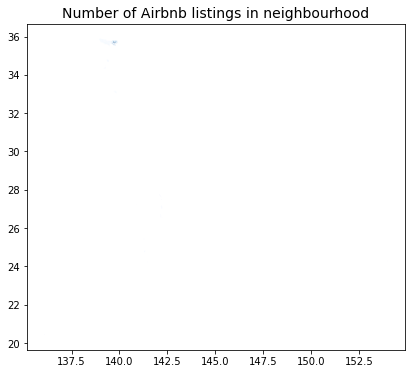

In [33]:
fig1, ax1 = plt.subplots(1, figsize=(15, 6))

tokyo_map.plot(column='total_listings', 
               cmap='Blues', 
               ax=ax1)

ax1.set_title('Number of Airbnb listings in neighbourhood', fontsize=14);

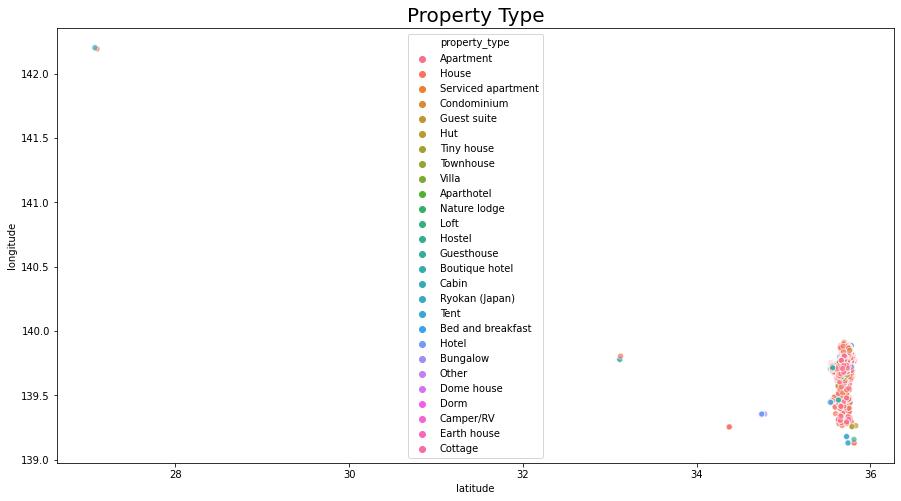

In [34]:
plt.figure(figsize=(15,8))
sns.scatterplot(x = 'latitude', 
                y = 'longitude', 
                hue = 'property_type', 
                data = final, 
                alpha = 0.7)
plt.title("Property Type", fontsize=20);

<div class="alert alert-block alert-success">

<b>Observation:</b>

Judging from the this scatter plot, there is some listings that are pretty out of norm (based on latitude and longitute. Hence I will be dropping those.

</div>

In [35]:
final.drop(final[final.latitude < 35].index, inplace=True)

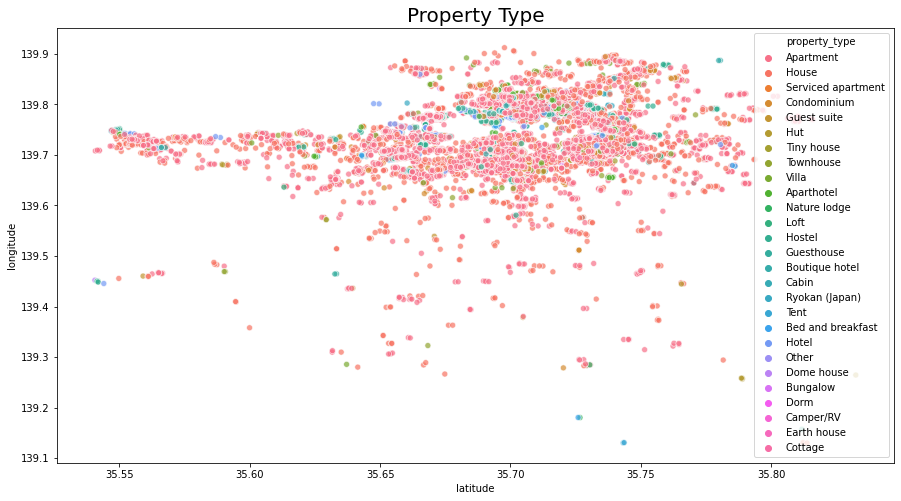

In [36]:
# plot scatter
plt.figure(figsize=(15,8))
sns.scatterplot(x = 'latitude', 
                y = 'longitude', 
                hue = 'property_type', 
                data = final, 
                alpha = 0.7)
plt.title("Property Type", fontsize=20);

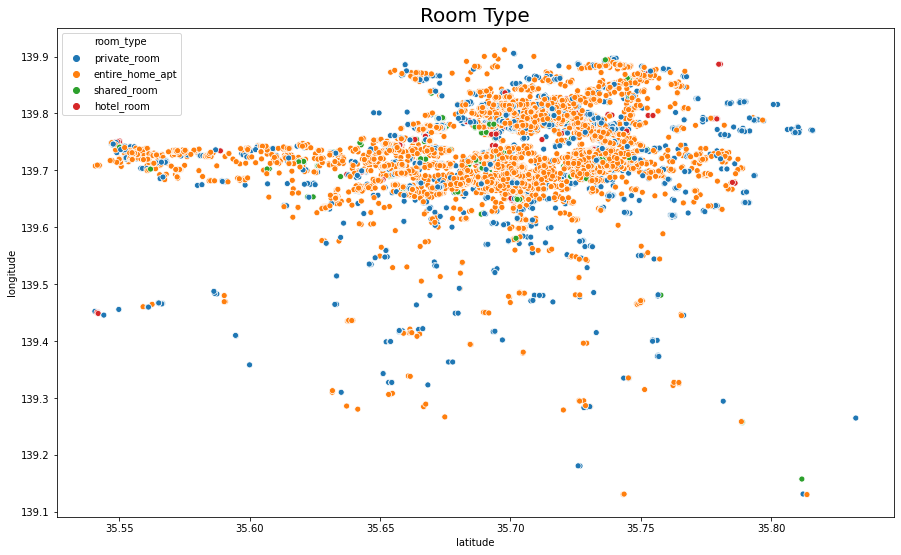

In [37]:
plt.figure(figsize=(15,9))
sns.scatterplot(x = 'latitude', 
                y = 'longitude', 
                hue = 'room_type', 
                data = final)
plt.title('Room Type', fontsize=20);

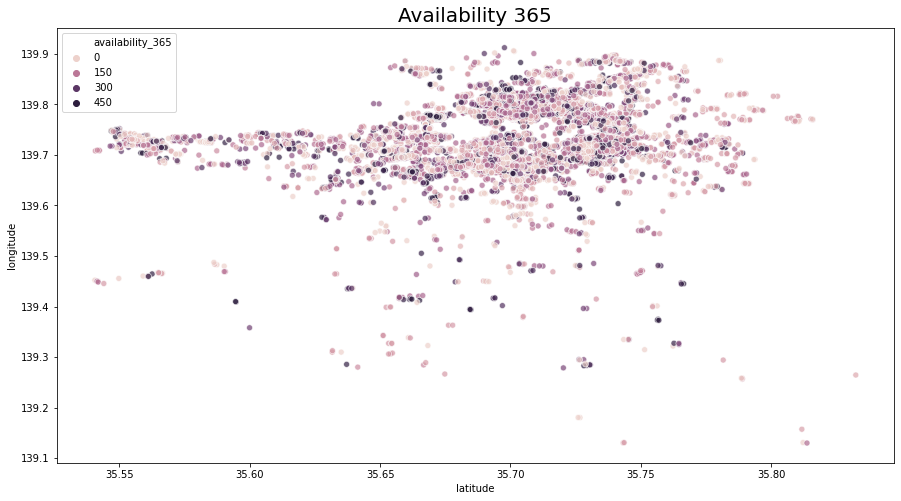

In [38]:
plt.figure(figsize=(15,8))
sns.scatterplot(x = 'latitude', 
                y = 'longitude', 
                hue = 'availability_365', 
                data = final, 
                alpha = 0.7)
plt.title("Availability 365", fontsize=20);

##  3. Time Series Analysis

##### a. Time Since First Review

In [39]:
# final['time_since_first_review'] = final.last_review - final.first_review
# final.time_since_first_review.hist(figsize=(11,9), bins=30);

## 4. Correlation

In [40]:
# sns.set(style="white")

# corr = final.corr()

# mask = np.zeros_like(corr, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True

# fig, ax = plt.subplots(figsize=(20,10))

# cmap = sns.diverging_palette(220, 10, as_cmap=True)

# sns.heatmap(corr, 
#             mask=mask, 
#             cmap=cmap, 
#             center=0, 
#             square=True, 
#             linewidths=.5, 
#             cbar_kws={"shrink": .5}, 
#             vmax=corr[corr != 1.0].max().max())

# ax.set_title('Collinearity between Features', fontsize=20);

In [41]:
# fig = plt.figure(figsize=(11,9))

# cmap = sns.diverging_palette(220, 10, as_cmap=True)

# sns.heatmap(final.corr()[['price']].sort_values(by='price', ascending=False), 
#             cmap=cmap, 
#             center=0, 
#             annot=True)

# plt.title('Correlation with price', fontsize=20)
# y_min, y_max = ax.get_ylim() 
# x_min, x_max = ax.get_xlim()
# ax.set_ylim(top=y_max+1) 
# ax.set_xlim(right=x_max-1);

##### Save Final Dataframe

In [42]:
final.to_csv("../datasets/final_df.csv", index = False)

----> Proceed to the next notebook for Feature Engineering and Model Bench Mark

##  <span style='background:yellow'> 1. Import Necessary Libraries & Load Data </span>  --- to break notebook

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# modelling
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.linear_model import LinearRegression
# from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
# from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score, accuracy_score
# import xgboost as xgb
# from xgboost import plot_importance


#Hide warnings
import warnings
warnings.filterwarnings('ignore')

In [44]:
# Load in Data 
df = pd.read_csv('../datasets/final_df.csv')
print(f"Total Number of Listing: {df.shape[0]} | Total Number of Features: {df.shape[1]}")
df.head().T

Total Number of Listing: 11435 | Total Number of Features: 46


,0,1,2,3,4
id,35303,197677,289597,370759,700253
host_id,151977,964081,341577,1573631,341577
host_since,2010-06-25,2011-08-13,2011-01-10,2012-01-06,2011-01-10
host_response_time,unknown,within a few hours,within a few hours,within a day,within a few hours
host_response_rate,unknown,100%,100%,100%,100%
host_acceptance_rate,unknown,50-89%,50-89%,90-99%,50-89%
host_is_superhost,0,1,0,1,0
host_listings_count,3,1,2,3,2
host_identity_verified,1,1,1,1,1
neighbourhood,Shibuya Ku,Sumida Ku,Nerima Ku,Setagaya Ku,Nerima Ku


## 2. Feature Engineering 

##### a. Categorical Variables

In [47]:
df = pd.get_dummies(df, columns=['property_type',
                                 'room_type',
                                 'cancellation_policy',
                                 'neighbourhood',
                                 'host_response_time',
                                 'host_acceptance_rate',
                                 'review_scores_rating',
                                 'review_scores_accuracy',
                                 'review_scores_cleanliness',
                                 'review_scores_checkin',
                                 'review_scores_communication',
                                 'review_scores_location',
                                 'review_scores_value',
                                 'instant_bookable',
                                 'is_location_exact'
                                ], 
                         drop_first = False)
df.shape

##### b. Amenities

In [49]:
all_amenities = df['amenities'].str.get_dummies(sep=',')
df = pd.concat([df, all_amenities], axis=1)
df.shape

(11435, 324)

In [ ]:
# all_amenities = df['amenities'].str.get_dummies(sep=',')
# all_amenities = pd.concat([df.price, all_amenities], axis=1)
# all_amenities.head()

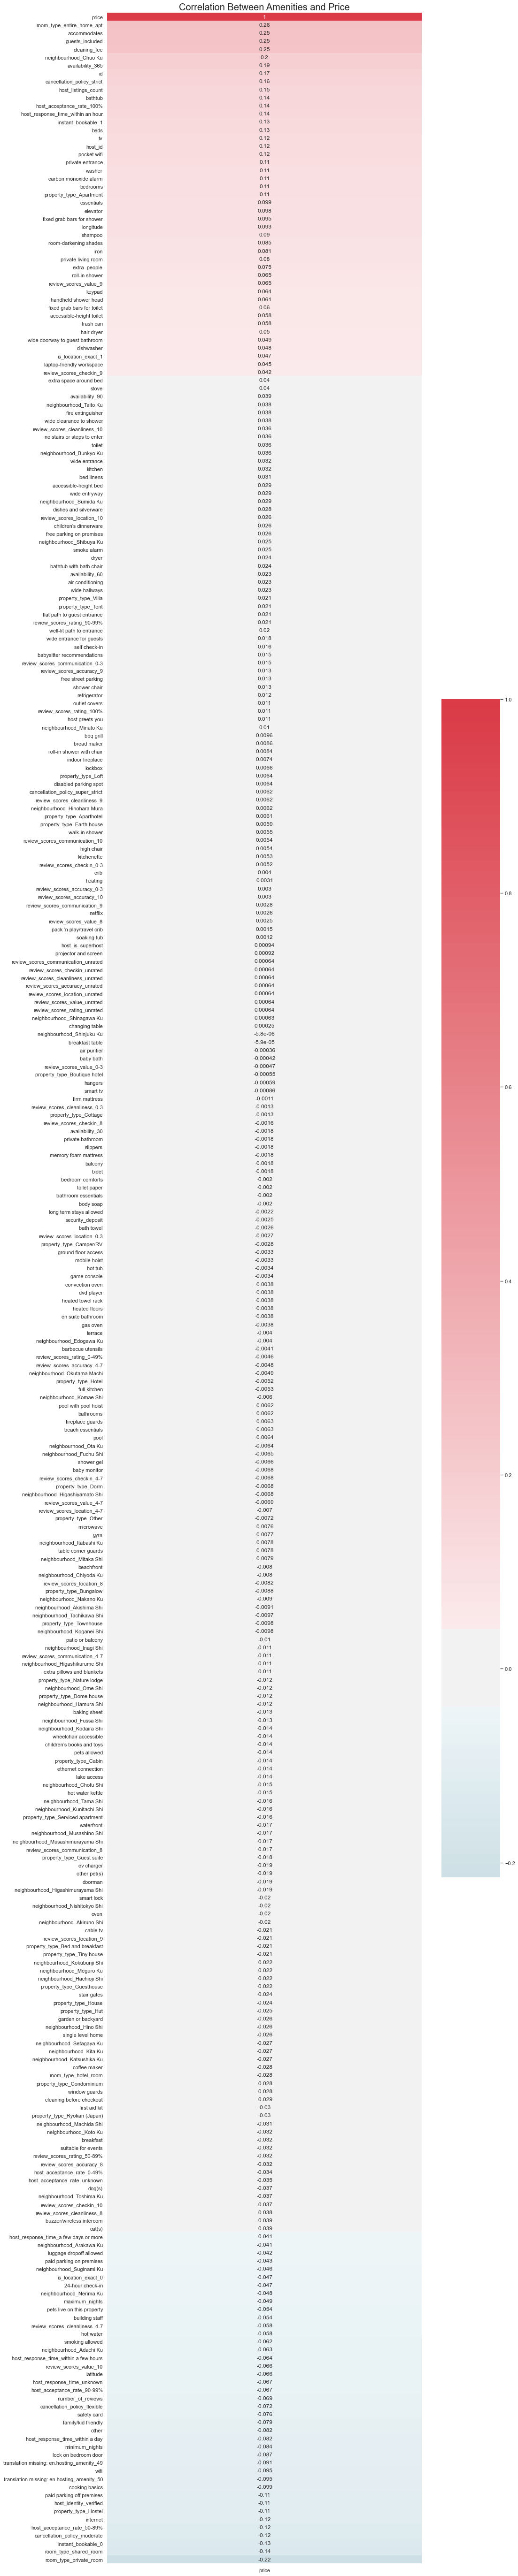

In [59]:
fig = plt.figure(figsize=(15,100))

cmap = sns.diverging_palette(220, 10, as_cmap=True)
corr = df.corr()

sns.heatmap(df.corr()[['price']].sort_values(by='price', ascending=False), 
            cmap=cmap, 
            center=0, 
            annot=True,
            cbar_kws={"shrink": .9},)

plt.title('Correlation Between Amenities and Price', fontsize=20)
y_min, y_max = ax.get_ylim() 
x_min, x_max = ax.get_xlim()
ax.set_ylim(top=y_max+1) 
ax.set_xlim(right=x_max-1);

## 3. Multicollinearity

In [57]:
df_copy = df

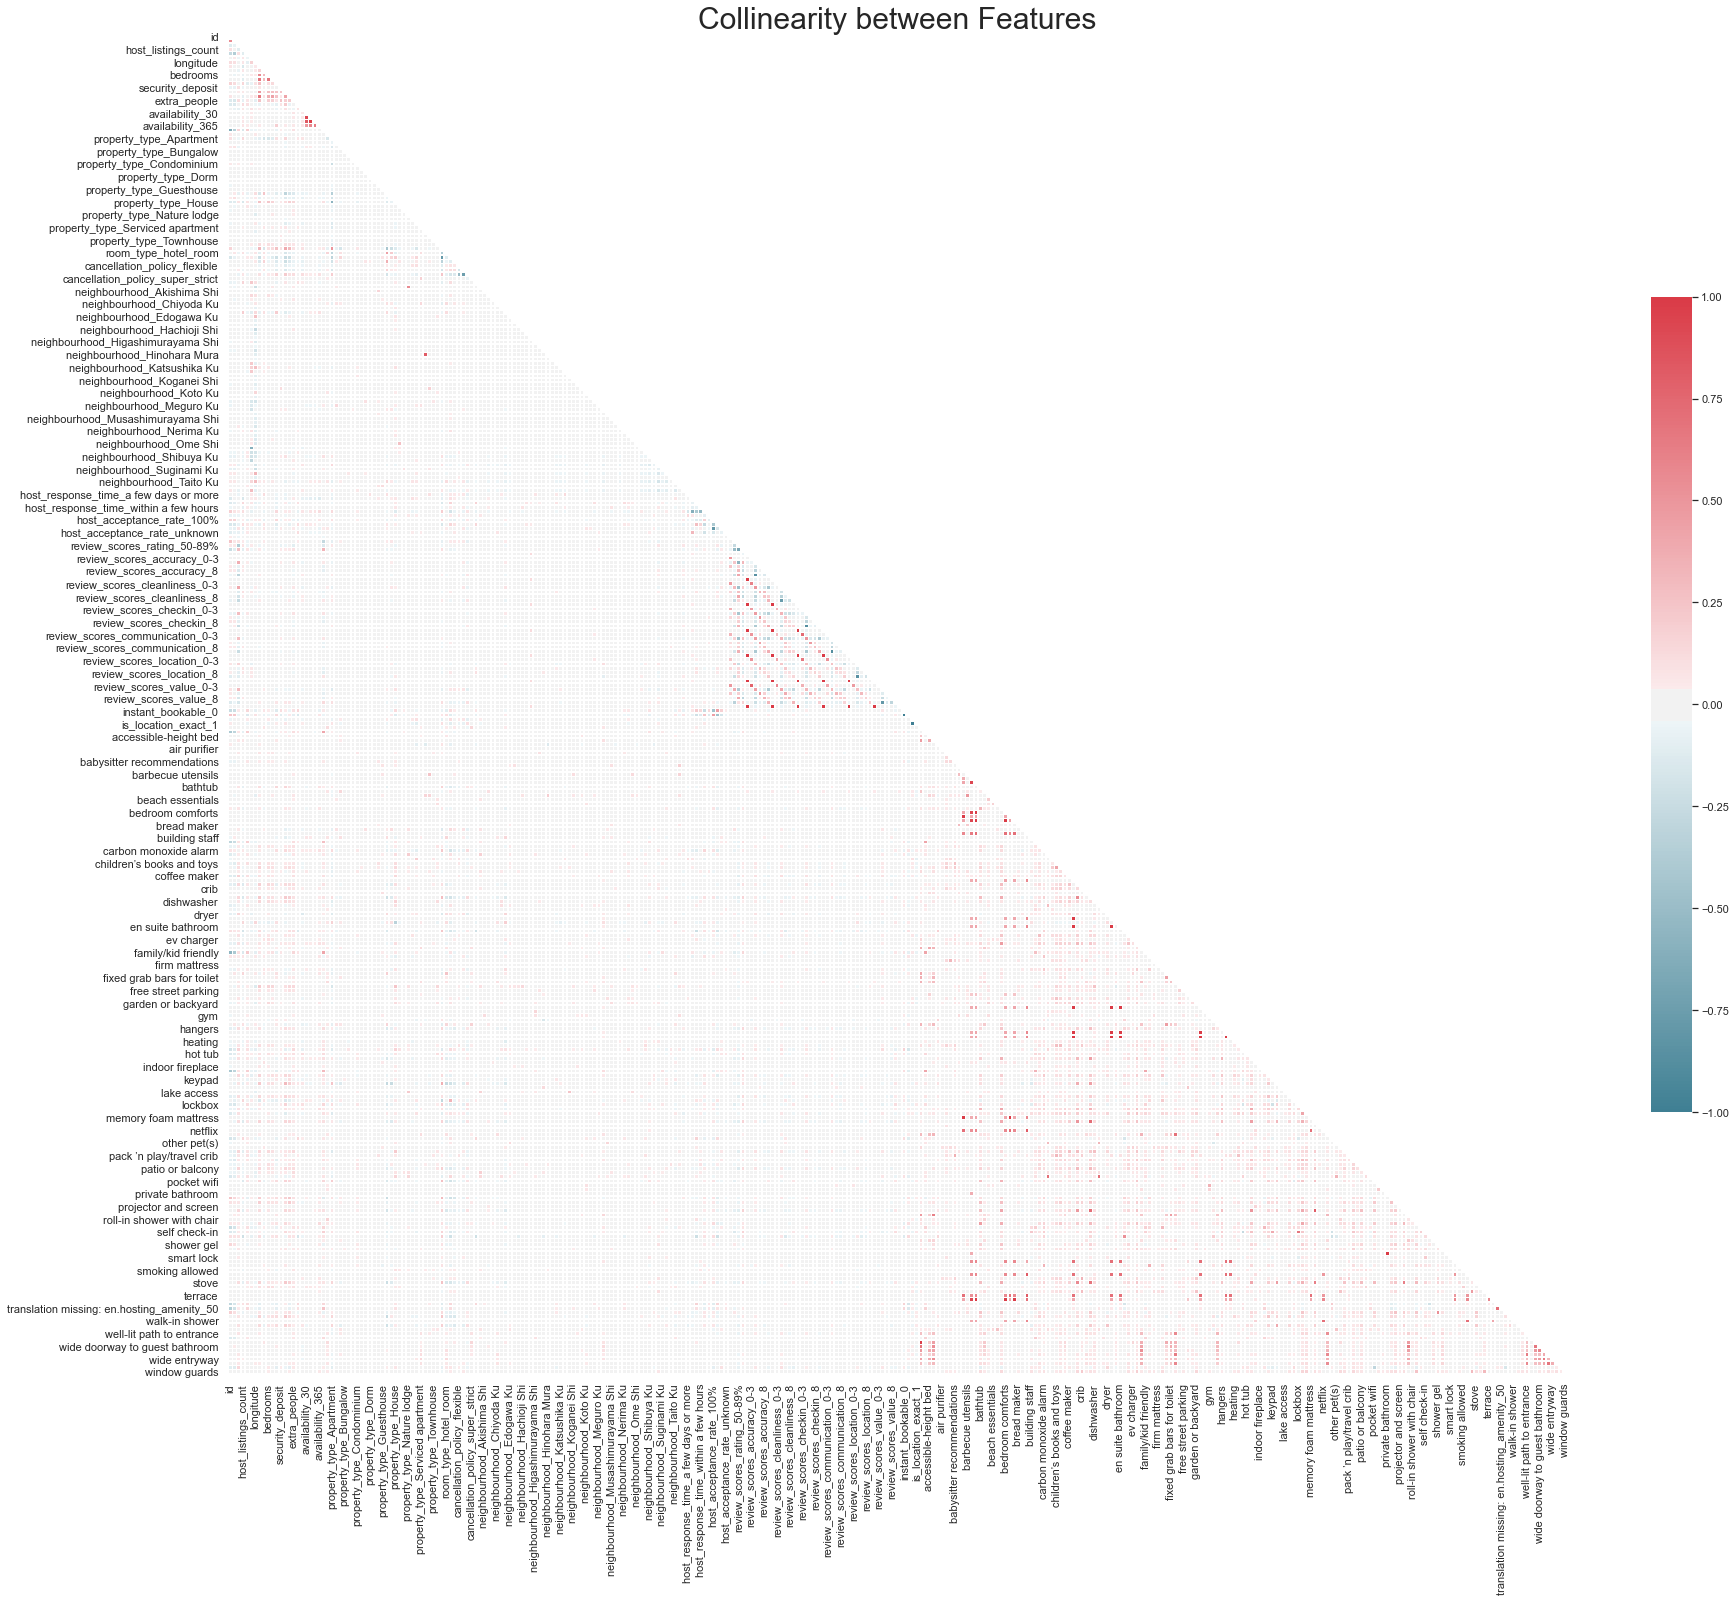

In [58]:
sns.set(style="white")

corr = df_copy.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(30,30))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, 
            mask=mask, 
            cmap=cmap, 
            center=0, 
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5})

ax.set_title('Collinearity between Features', fontsize=30);

## <span style='background:yellow'> 4. Model Prep </span>
##### i. Create X and y variables

In [60]:
features = [col for col in df._get_numeric_data().columns if col != 'price']

X = df[features]
y = df['price']

#####  ii. Baseline Prediction 

In [61]:
# The mean value of the target vector (y).
np.mean(y)

17990.367118495848

<div class="alert alert-block alert-success">

<b>Observation:</b>

Without any regression modelling, the predicted value for every data point is 17990¥.

</div>

##### iii. Train/Test Split

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2)

In [63]:
ss = StandardScaler()
ss.fit(X_train)
X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

##### iv. Baseline score

In [64]:
# Instantiate Model
lr = LinearRegression()

# cross_val_score for Logistic Regression.
print("Accuracy of Model with Cross-Validation: {}".format(cross_val_score(lr, 
                                                                           X_train_ss, 
                                                                           y_train, 
                                                                           cv=5).mean()))

Accuracy of Model with Cross-Validation: -5.449355405364014e+25


The evaluation metrics used will be mean squared error (for loss) and r squared (for accuracy).

In [ ]:
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))